# Various CNNs

1. AlexNet
2. VGG
3. GoogleNet
4. ResNet

In [ ]:
!pip install torch torchvision --quiet


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

classes = trainset.classes


100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return loss_sum / len(loader), 100 * correct / total


def test(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total


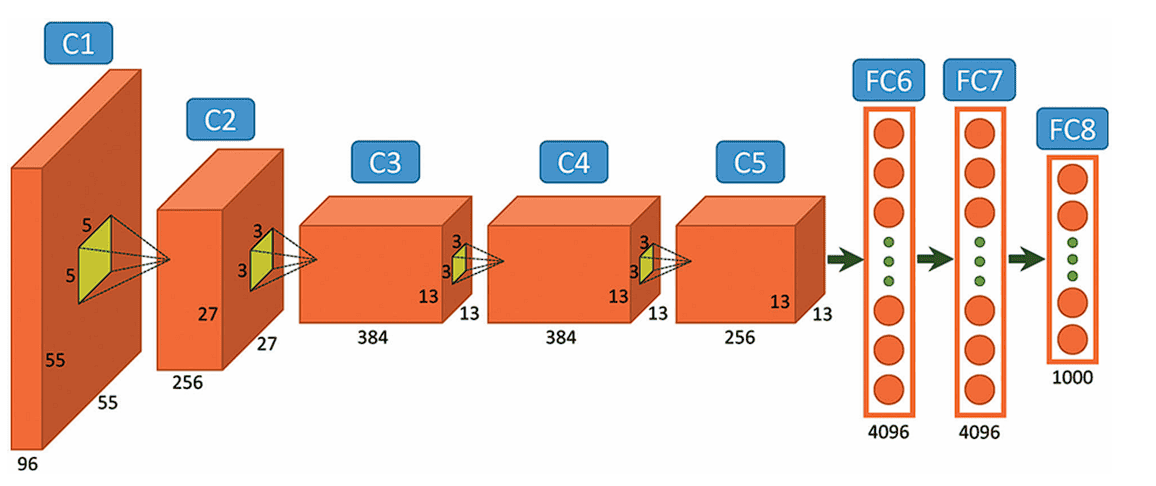

# AlexNet

AlexNet은 ImageNet 대회에서 기존 SOTA를 크게 뛰어넘은 딥러닝 기반 CNN 모델로,
ReLU·Dropout·GPU 학습·Data Augmentation 등 현대 딥러닝의 핵심 요소를 도입하여
컴퓨터 비전의 딥러닝 시대를 연 모델이다.

1) 딥러닝(New CNN Era)을 연 모델

ImageNet 2012에서 기존 대비 10.9% → 15.4% 개선이라는 압도적인 성능 향상을 이뤄 CV 패러다임을 바꿈.

2) 모델 구조 (총 5개의 Conv + 3개의 FC)

3) ReLU 도입 (Sigmoid/Tanh보다 훨씬 빠른 학습)

ReLU가 gradient vanishing을 줄여주어 깊은 네트워크 학습을 가능하게 함.

4) GPU 2개를 활용한 병렬 구조

당시 GPU 메모리가 부족해서 네트워크를 둘로 나눠 2개의 GPU에서 병렬 학습하였다.
(현대 구현에서는 필요 없음)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 11, stride=4, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(64, 192, 5, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
model = AlexNet().to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(3):
    loss, acc = train(model, trainloader, optimizer, criterion)
    print(f"[Epoch {epoch+1}] Loss: {loss:.4f}, Train Acc: {acc:.2f}%")

print("Test Acc:", test(model, testloader))


[Epoch 1] Loss: 1.6055, Train Acc: 40.44%
[Epoch 2] Loss: 1.1756, Train Acc: 57.41%
[Epoch 3] Loss: 0.9507, Train Acc: 66.22%
Test Acc: 70.52


# VGG

VGG(2014)는 단순한 설계(모든 Conv를 3×3으로 통일 + 깊이 증가)를 통해
CNN의 깊이가 성능 향상에 결정적임을 증명한 모델이다.
구조적 단순함과 규칙성 때문에 현재까지도 CNN 설계의 표준으로 활용된다.

1) 단순하고 규칙적인 CNN 구조

모든 Convolution layer를 3×3 kernel, stride 1, padding 1로 통일하여
구조를 단순화하며 깊이를 크게 늘림.

2) 깊이가 성능을 결정한다는 것을 증명

VGG16/19는 AlexNet 대비 훨씬 깊지만 설계는 훨씬 더 단순함.
→ 네트워크가 깊을수록 성능이 좋아진다는 사실을 명확히 입증

3) 작은 필터 반복으로 receptive field 확장

1개의 7×7 conv 대신

3×3 conv 두 개(또는 세 개)를 쌓아서 동일한 receptive field 확보 + 파라미터 절약 + 더 많은 비선형성

4) 매우 큰 파라미터 수

결과적으로 FC layer의 크기 때문에 총 파라미터 수가 매우 크다 (약 138M).

5) Transfer Learning의 표준 모델

VGG는 단순하고 안정적이어서 Feature extractor로 활용.
Pretrained weights 기반 fine-tuning이 매우 널리 사용되었다.

----

**VGG의 기본 철학**

“작은 필터(3×3)를 많이 쌓아서 심층 구조를 만든다.”

(3×3 conv → 3×3 conv → pool) × N\
의 규칙적인 패턴만 반복된다.

**Conv Blocks:**\
Block1: 3×3 conv, 64 → 64 → maxpool\
Block2: 3×3 conv, 128 → 128 → maxpool\
Block3: 3×3 conv, 256 → 256 → 256 → maxpool\
Block4: 3×3 conv, 512 → 512 → 512 → maxpool\
Block5: 3×3 conv, 512 → 512 → 512 → maxpool

**FC layers**:\
FC6: 4096\
FC7: 4096\
FC8: 1000 (ImageNet)

----

# 왜 3×3 conv?!

1. 7×7 conv 한 개와 동일한 receptive field 확보 가능
(3×3 conv를 3개 쌓으면 7×7 receptive field)

2. 하지만 파라미터 수는 더 적음

* 7×7 conv: 매우 많은 파라미터

* 3×3 conv × 3: 더 작음

3. 비선형성이 더 많아짐 (ReLU 2~3번 추가)
→ 더 복잡한 패턴 학습 가능

즉, 작은 conv를 여러 개 쌓으면 동일한 공간적 정보를 더 적은 파라미터로 더 깊게, 더 강력하게 학습할 수 있다\
라는 인사이트를 제시한 모델.

----


# VGG의 특징

1.Zero-padding 적극 사용

3×3 conv에서 항상 padding=1로 spatial 크기를 유지.

2. 매우 대규모 데이터 사용

ImageNet (약 120만 장)으로 학습.

3. 매우 큰 모델

약 138M 파라미터. 주로 FC layer 때문에 큼.

4.계산량이 매우 큼 (연산 FLOPs도 크다)

이후 GoogLeNet과 ResNet이 등장하여 효율 개선됨.

----

VGG-16 vs VGG-19

**VGG-16**\
Block 1: 64   - 64\
Block 2: 128  - 128\
Block 3: 256  - 256  - 256\
Block 4: 512  - 512  - 512\
Block 5: 512  - 512  - 512\
\+ FC6, FC7, FC8

**VGG-19**\
Block 1: 64   - 64\
Block 2: 128  - 128\
Block 3: 256  - 256  - 256  - 256   ← 추가\
Block 4: 512  - 512  - 512  - 512   ← 추가\
Block 5: 512  - 512  - 512  - 512   ← 추가\
\+ FC6, FC7, FC8

VGG-19는 VGG-16에서 Block 3·4·5에 conv layer를 각각 한 개씩 추가한 버전이다.\
즉, Conv 13개 → 16개가 되어서 total 19개의 weight layer가 된다.

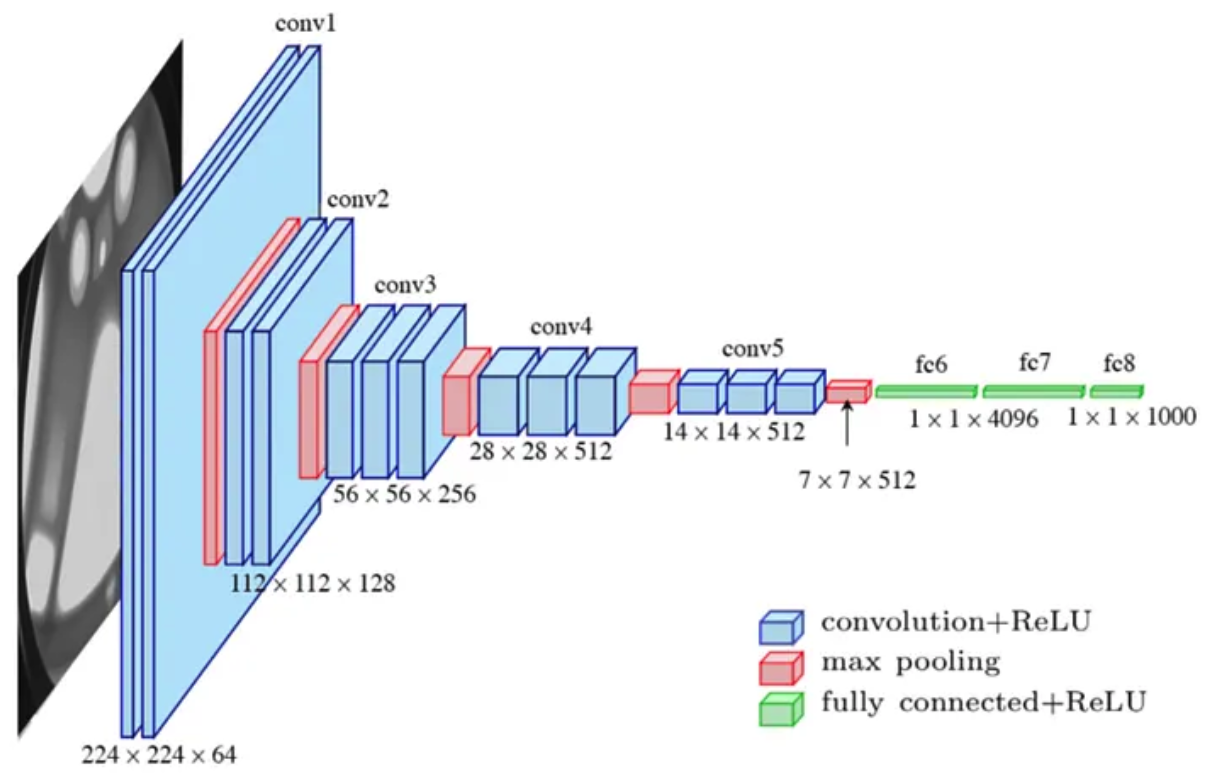

In [ ]:
from torchvision.models import vgg16

model = vgg16(weights=None)
model.classifier[6] = nn.Linear(4096, 10)
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(3):
    loss, acc = train(model, trainloader, optimizer, criterion)
    print(f"[Epoch {epoch+1}] Loss: {loss:.4f}, Train Acc: {acc:.2f}%")

print("Test Acc:", test(model, testloader))


[Epoch 1] Loss: 1.5843, Train Acc: 41.60%


KeyboardInterrupt: 

# GoogLeNet (2014)

GoogLeNet(Inception v1)은 다양한 크기의 필터(1×1, 3×3, 5×5)를 동시에 병렬로 적용해 정보를 종합하는 멀티-스케일 CNN 구조를 제안했다.\
또한*1×1 convolution을 활용한 차원 축소(Feature Compression)로 연산량을 크게 줄여, 깊은 네트워크를 효율적으로 구현할 수 있게 했다.

1) Multi-scale feature extraction

한 층에서 동시에 다양한 receptive field를 적용:

* 1×1 conv → identity-like small-scale

* 3×3 conv → middle-scale

* 5×5 conv → large-scale

* Max-pool → coarse-scale

이렇게 여러 스케일의 정보를 병렬로 추출해 concat하는 구조가 핵심.

2) 1×1 Convolution을 통한 차원 축소 (Bottleneck 역할)

큰 커널(3×3, 5×5)은 매우 연산량이 크다.
이를 해결하기 위해 각 branch 앞에 1×1 conv를 넣고 channel을 줄여 비용 축소.

→ “비용은 줄이고 표현력은 유지하는” 혁신적 설계

3) 매우 깊은 구조를 효율적으로 학습

총 22개의 weight layer
(VGG보다 더 깊지만 연산량은 훨씬 적다)

4) Auxiliary Classifiers

중간 블록에 작은 보조 classifier를 달아 gradient 흐름 개선 + regularization 효과.

5) 연산량 대비 정확도가 매우 우수한 모델

GoogLeNet은 당시 SOTA이면서도 AlexNet 대비 10배 이상 연산량 감소.

----

# GoogleNet, Inception Module이 갖는 의미

1) 연산 효율 혁명

VGG 대비 성능 비슷하거나 더 좋지만
연산량은 훨씬 적음.
(e.g., VGG16: 138M params but GoogLeNet: 6.8M params (!!))

2) Multi-scale feature extraction의 중요성 부각

CNN이 다양한 공간적 패턴을 동시에 처리해야 함을 보여줌.

3) 1×1 conv의 강력함을 보여줌

이후:

* ResNet

* SqueezeNet

* MobileNet

EfficientNet
모두 1×1 conv를 핵심 요소로 사용.

4) Auxiliary classifier로 deep network 학습 안정화

→ ResNet에서는 skip connection으로 대체됨

5) Global Average Pooling 도입

FC layer를 줄이고 generalization 향상
→ 이후 CNN 대부분이 GAP 사용

----

# Global Average Pooling

GAP는 (C × H × W) feature map을 → (C) 벡터로 줄이는 연산

공간 차원(H, W)을 1×1로 압축하고 channel만 남긴다.

**왜 쓸까?**

FC Layer를 대체 → 파라미터 엄청 감소

GoogLeNet 이전 CNN은 마지막에서:

7×7×1024 → FC → 4096 → 1000


이런 구조를 사용했는데
FC layer가 파라미터 대부분을 차지하는 주범이었다.

하지만 GAP를 쓰면,

7×7×1024 → GAP → 1024 → FC(1024 → 1000)


→ 모델 크기가 극적으로 감소.


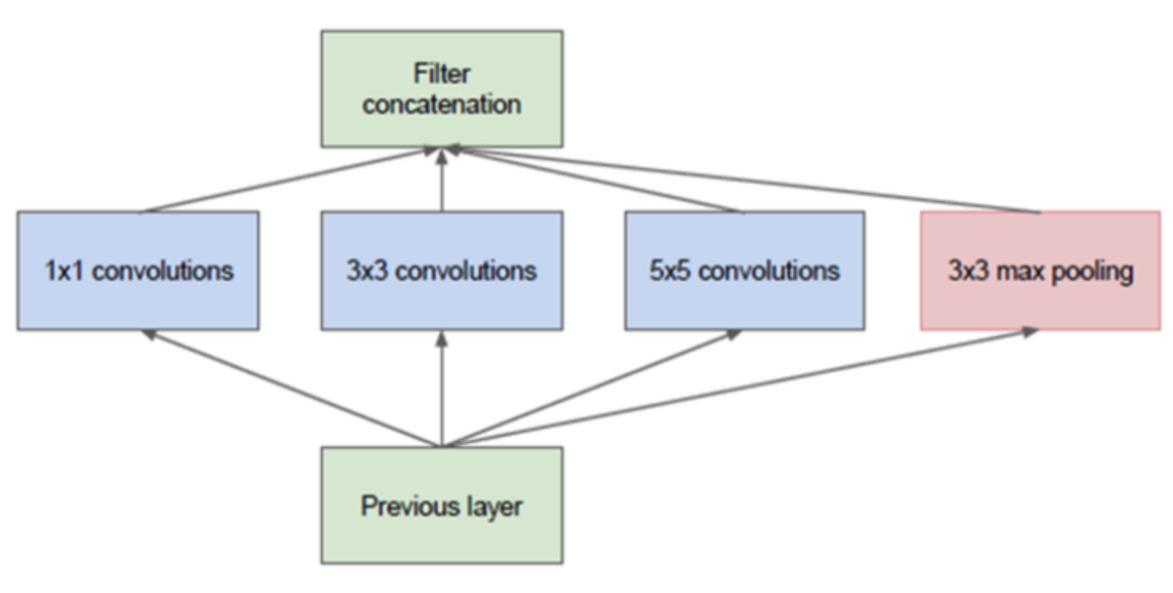

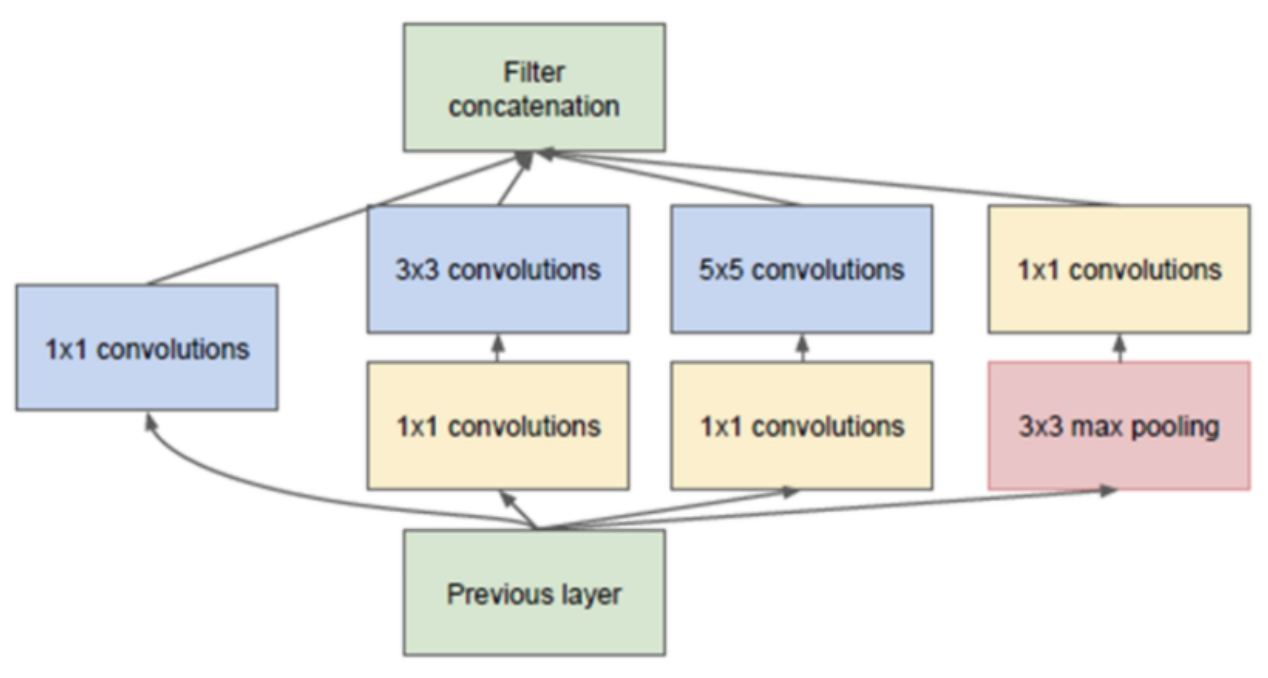

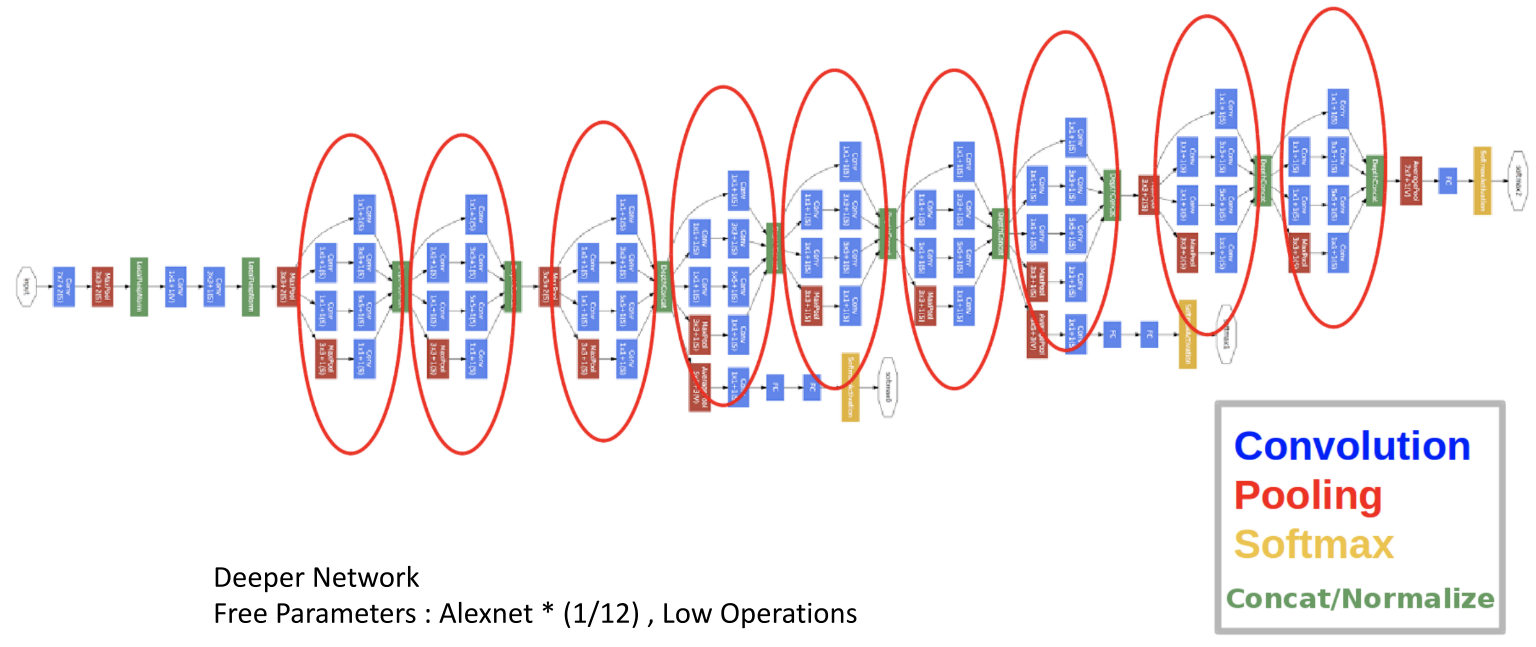

In [ ]:
from torchvision.models import googlenet

model = googlenet(weights=None, aux_logits=False)
model.fc = nn.Linear(1024, 10)
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(3):
    loss, acc = train(model, trainloader, optimizer, criterion)
    print(f"[Epoch {epoch+1}] Loss: {loss:.4f}, Train Acc: {acc:.2f}%")

print("Test Acc:", test(model, testloader))

KeyboardInterrupt: 

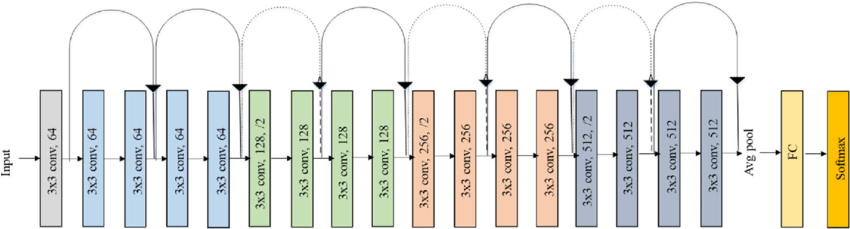

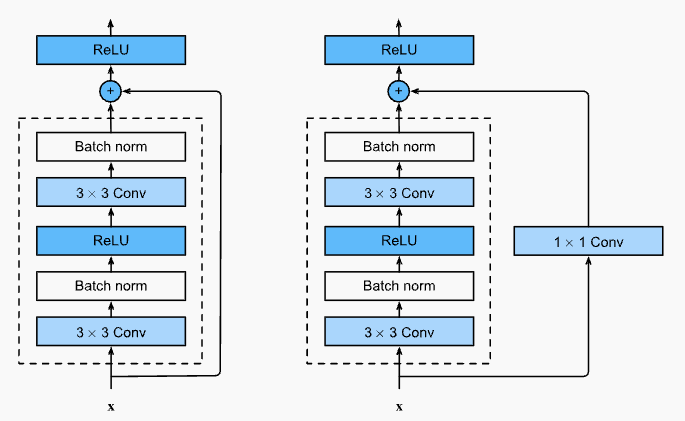

# ResNet (2015)

ResNet Residual Connection(잔차 연결)을 도입하여 딥러닝의 학습 불가능했던 깊이 문제(vanishing gradient)를 해결하고,
VGG보다 훨씬 더 깊은 네트워크(50/101/152층)를 성공적으로 학습시킨 혁명적 모델이다.

1. Residual Block = Identity Mapping Shortcut

기존 CNN은 layer가 깊어질수록 gradient가 사라지고(소실),
오히려 깊은 모델이 얕은 모델보다 성능이 떨어지는 Degradation Problem이 있었다.

ResNet은 다음 형태의 shortcut을 도입함으로써 문제를 해결했다: 𝑦 = 𝐹(𝑥)+𝑥

즉,

* F(x) : 여러 개의 Conv/BN/ReLU로 이루어진 변환

* x : 변환되지 않은 입력 (identity shortcut)

이 skip connection 덕분에 gradient가 직접 흐를 수 있어 아주 깊은 네트워크도 안정적으로 학습 가능해졌다.

2. “깊을수록 성능이 좋아진다”를 진짜로 실현한 첫 모델

VGG는 깊이를 늘리면 성능이 좋아지지만 (16→19)
그 이상에서는 학습이 불안정해졌다.

ResNet은
* 50-layer
* 101-layer
* 152-layer

같은 초심층 모델도 쉽게 학습해버렸다.

3. Skip connection이 생기며 최적화 난이도가 급격히 낮아짐

잔차 연결은
* Gradient 흐름 안정화

* Identity mapping 보장

* Parameter initialization 의존도 감소

→ 딥러닝 훈련 자체를 더 “쉽게” 만들었다.

4. Bottleneck 구조로 깊이를 효율적으로 증가

3-layer block 구조:

1×1 conv  (채널 축소)\
3×3 conv  (main conv)\
1×1 conv  (채널 확장)

→ 연산량은 줄이고 depth는 늘린 설계.

----

**ResNet의 기본 철학**

“학습하려는 함수 H(x) 대신, residual F(x) = H(x) - x 를 학습하자.”

즉, 직접 mapping을 학습하는 대신 “입력 대비 얼마나 변화시키는가?”만 학습

이는 최적화가 훨씬 쉬워진다.

**ResNet 전체 흐름 (ResNet-18 기준)**

7×7 conv → BN → ReLU → MaxPool

Stage 1 (64ch):   BasicBlock × 2\
Stage 2 (128ch):  BasicBlock × 2\
Stage 3 (256ch):  BasicBlock × 2\
Stage 4 (512ch):  BasicBlock × 2

Global Average Pooling\
FC → Softmax

----

# ResNet의 특징

1. 매우 깊은 모델 학습 가능

152-layer도 안정적으로 학습 성공 (당시 혁명적)

2. Parameter 수는 VGG보다 훨씬 적음

* VGG16: 138M

* ResNet50: ~25M

3. Skip connection은 이후 모든 모델의 기본 요소로 자리잡음

→ DenseNet, EfficientNet, Vision Transformer의 residual block까지\
→ 딥러닝 전반에 “residual design”이 표준화됨

4. BatchNorm 기반 디자인

* Conv → BN → ReLU
* bias=False

----

# ResNet은 CNN 역사에서 아주 중요한 의미

AlexNet → VGG → GoogLeNet → ResNet의 흐름 중\
ResNet은 결정적으로 다음을 해결함:

“딥러닝은 깊이가 한계다” → “아무리 깊어도 된다”\
“학습이 어렵다” → “Skip connection으로 해결된다”\
“효율 + 성능 + 안정성” 세 마리 토끼 잡음

그래서 오늘날까지도 “ResNet block”은 비전 모델의 표준 구성 블록 역할!

-----

한 줄 요약:
**ResNet은 Residual Connection(잔차 연결)을 도입하여 매우 깊은 네트워크를 안정적으로 학습할 수 있게 만든 혁명적인 CNN 모델이며, 딥러닝 최적화 문제를 근본적으로 해결한 기념비적 아키텍처이다.**

In [ ]:
from torchvision.models import resnet18

model = resnet18(weights=None)
model.fc = nn.Linear(512, 10)
model = model.to(device)


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(3):
    loss, acc = train(model, trainloader, optimizer, criterion)
    print(f"[Epoch {epoch+1}] Loss: {loss:.4f}, Train Acc: {acc:.2f}%")

print("Test Acc:", test(model, testloader))

[Epoch 1] Loss: 1.2823, Train Acc: 53.45%
[Epoch 2] Loss: 0.8870, Train Acc: 68.78%
[Epoch 3] Loss: 0.6659, Train Acc: 76.96%
Test Acc: 68.35
